In [1]:
import os

from pathlib import Path
import torch
import pandas as pd

import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
import tqdm

import torch                    
import torchvision

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = os.getcwd()
# os.chdir("/content/drive/MyDrive/MA4/Deep Learning")
# path = os.getcwd()

In [2]:
path = os.getcwd()
df = pd.read_json(path + '/archive/MMHS150K_GT.json', orient='index')
df.sample(5)

,img_url,labels,tweet_url,tweet_text,labels_str
2005-02-06 01:21:45.941778432,http://pbs.twimg.com/media/D18scj9WkAExlG5.jpg,"[0, 1, 0]",https://twitter.com/user/status/11076529059417...,Aight it’s looking bad out here. I don’t wanna...,"[NotHate, Racist, NotHate]"
2003-08-19 23:51:59.430504449,http://pbs.twimg.com/media/DrqgekeWoAAAHTH.jpg,"[5, 5, 0]",https://twitter.com/user/status/10613371194305...,@bojboj7 retard https://t.co/scP6W0Y35E,"[OtherHate, OtherHate, NotHate]"
2005-04-28 16:47:01.430808576,http://pbs.twimg.com/tweet_video_thumb/D3g78T4...,"[0, 0, 0]",https://twitter.com/user/status/11147068214308...,@Teddy_Smith504 Nigga... HUSH! https://t.co/YU...,"[NotHate, NotHate, NotHate]"
2005-04-16 07:23:15.018391552,http://pbs.twimg.com/media/D3RuN7RW4AEa7DV.jpg,"[0, 5, 0]",https://twitter.com/user/status/11136361950183...,Celtic news: Rangers manager Steven Gerrard sa...,"[NotHate, OtherHate, NotHate]"
2005-03-05 09:42:15.206567936,http://pbs.twimg.com/tweet_video_thumb/D2eRbDy...,"[0, 1, 0]",https://twitter.com/user/status/11100157352065...,@RealJamesWoods ❤️🇺🇸💙✅Exactly ..... No Mercy! ...,"[NotHate, Racist, NotHate]"


In [3]:
# labels: 0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate

# extract tweet id from tweet url
df['tweet_id'] = df['tweet_url'].apply(lambda x: x.split('/')[-1])

# create a new column for each label
df['is_hateful'] = df['labels'].apply(lambda x: x !=[0,0,0])
# create a new column for each label
df['is_racist'] = df['labels'].apply(lambda x: 1 in x)
df['is_sexist'] = df['labels'].apply(lambda x: 2 in x)
df['is_homophobe'] = df['labels'].apply(lambda x: 3 in x)
df['is_religion'] = df['labels'].apply(lambda x: 4 in x)
df['is_other_hate'] = df['labels'].apply(lambda x: 5 in x)

# remove the labels column
df = df.drop(columns=['labels'])
# remove the labels_str column
df = df.drop(columns=['labels_str'])

# reset index => remove date and get a new index
df = df.reset_index(drop=True)

# for each row I want to count the number of labels True ('is_racist', 'is_sexist', 'is_homophobe', 'is_religion', 'is_other_hate')
df['n_labels'] = df[['is_racist', 'is_sexist', 'is_homophobe', 'is_religion', 'is_other_hate']].sum(axis=1)

Lets create a subset of data

In [5]:
# Now I want to create a subset of the data with equal number of hateful and non-hateful tweets
# for hateful, to make it easier, we will consider only the tweets multiple labels 
# (i.e., n_labels > 1)
number_of_samples = 15000

df_hateful = df[(df['is_hateful'] == True) & (df['n_labels'] > 1)]
df_non_hateful = df[df['is_hateful'] == False]

df_hateful = df_hateful.sample(n=int(number_of_samples/2), random_state=42)
df_non_hateful = df_non_hateful.sample(n=int(number_of_samples/2), random_state=42)

df_sample = pd.concat([df_hateful, df_non_hateful], axis=0)

print(df_sample.is_hateful.value_counts())

# save
df_sample.to_csv(path + '/data/MMHS150K_GT.csv', index=False)

df_sample.head()

is_hateful
True     7500
False    7500
Name: count, dtype: int64


,img_url,tweet_url,tweet_text,tweet_id,is_hateful,is_racist,is_sexist,is_homophobe,is_religion,is_other_hate,n_labels
4433,http://pbs.twimg.com/media/D2UK7nbWkAACbX6.jpg,https://twitter.com/user/status/11093049067527...,i got the strap like a dyke https://t.co/9aAST...,1109304906752708609,True,False,True,True,False,False,2
104707,http://pbs.twimg.com/media/Dof2ySxWkAU8fzc.jpg,https://twitter.com/user/status/10470770962526...,"""Oin oin oin, les SJW ont vandalisé Doctor Who...",1047077096252682240,True,False,True,False,False,True,2
11500,http://pbs.twimg.com/ext_tw_video_thumb/111420...,https://twitter.com/user/status/11142665122678...,Oh my God 😭😭😭😭😭😭😭 RT @melvitto: Bloop RT @Beat...,1114266512267857922,True,True,True,False,False,False,2
96401,http://pbs.twimg.com/media/Dq8UJJqWwAAAx69.jpg,https://twitter.com/user/status/10580866059431...,I was naughty... I need load deep in my cunt A...,1058086605943177217,True,False,True,False,False,True,2
130173,http://pbs.twimg.com/media/DnakUChU0AAgbS2.jpg,https://twitter.com/user/status/10422014204207...,can we talk about what a bold ass dyke izzie i...,1042201420420792320,True,False,False,True,False,True,2


Récupération des images associées

In [6]:
# we need to restrure the image folder
# to be able to use the torchvision.transforms
# not_hateful images need to be in the folder not_hateful
# hateful images need to be in the folder hateful
from os.path import join
import os
import shutil

# create the folders
os.makedirs("data/images/not_hateful", exist_ok=True)
os.makedirs("data/images/hateful", exist_ok=True)

# clear data folders
shutil.rmtree("data/images/not_hateful")
shutil.rmtree("data/images/hateful")

# create the folders
os.makedirs("data/images/not_hateful", exist_ok=True)
os.makedirs("data/images/hateful", exist_ok=True)

# for image in images:
for image in df_sample['tweet_id']:
    if not os.path.exists(join("archive/img_resized", f"{image}.jpg")):
        print(f"Image {image} not found")
        continue
    # if the image is hateful
    if df_sample[df_sample['tweet_id'] == image]['is_hateful'].values[0]:
        # move the image to the hateful folder
        source = join("archive/img_resized", f"{image}.jpg")
        destination = join("data/images/hateful", f"{image}.jpg")
    else:
        # move the image to the not hateful folder
        source = join("archive/img_resized", f"{image}.jpg")
        destination = join("data/images/not_hateful", f"{image}.jpg")
                
    shutil.copy(source, destination)

In [7]:
## training parameters to be used for all models ##
num_train_epochs = 5
batch_size = 16
learning_rate = 1e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

In [8]:
df = pd.read_csv(path + '/data/MMHS150K_GT.csv')
df.head()

,img_url,tweet_url,tweet_text,tweet_id,is_hateful,is_racist,is_sexist,is_homophobe,is_religion,is_other_hate,n_labels
0,http://pbs.twimg.com/media/D2UK7nbWkAACbX6.jpg,https://twitter.com/user/status/11093049067527...,i got the strap like a dyke https://t.co/9aAST...,1109304906752708609,True,False,True,True,False,False,2
1,http://pbs.twimg.com/media/Dof2ySxWkAU8fzc.jpg,https://twitter.com/user/status/10470770962526...,"""Oin oin oin, les SJW ont vandalisé Doctor Who...",1047077096252682240,True,False,True,False,False,True,2
2,http://pbs.twimg.com/ext_tw_video_thumb/111420...,https://twitter.com/user/status/11142665122678...,Oh my God 😭😭😭😭😭😭😭 RT @melvitto: Bloop RT @Beat...,1114266512267857922,True,True,True,False,False,False,2
3,http://pbs.twimg.com/media/Dq8UJJqWwAAAx69.jpg,https://twitter.com/user/status/10580866059431...,I was naughty... I need load deep in my cunt A...,1058086605943177217,True,False,True,False,False,True,2
4,http://pbs.twimg.com/media/DnakUChU0AAgbS2.jpg,https://twitter.com/user/status/10422014204207...,can we talk about what a bold ass dyke izzie i...,1042201420420792320,True,False,False,True,False,True,2


# TESTS

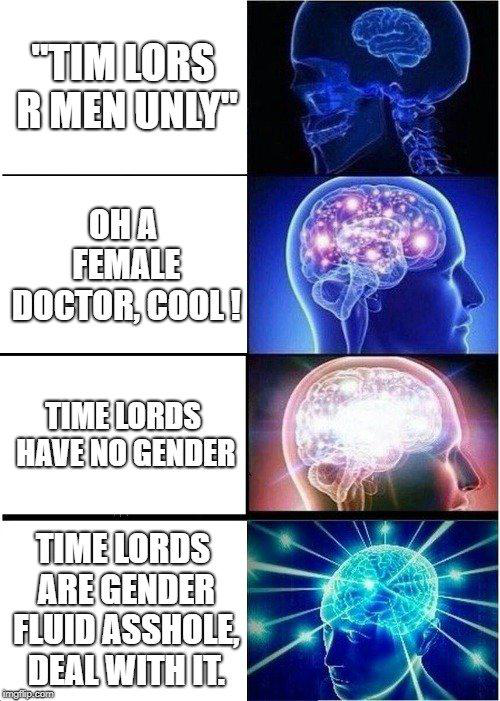

In [19]:
from PIL import Image

id = 1

tweet = df.iloc[id]
image = Image.open(path + '/archive/img_resized/' + str(df['tweet_id'].iloc[id]) + '.jpg')
display(image)

In [49]:
text = "This image is hateful"
tweet_text = tweet['tweet_text']

In [ ]:
ocr_text = pd.read_json(path + '/archive/img_txt/{id}.json', orient='index')

In [115]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import random

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

predicted = []
true_values = []

for i in random.sample(range(0, 15000), 100):
    id = i
    tweet_text = df['tweet_text'].iloc[id]
    tweet_id = df['tweet_id'].iloc[id]
    tweet_label = df['is_hateful'].iloc[id]
    
    # ocr_text = None
    
    # if os.path.exists(path + '/archive/img_text/' + str(tweet_id) + '.jpg'):
    #     ocr_text = pd.read_json(path + '/archive/img_txt/' + str(tweet_id) + '.json', orient='index')
    #     print(ocr_text)
    
    img_path = "archive/img_resized/" + str(tweet_id) + ".jpg"
    
    text = "Is this hateful? " + tweet_text # + " and " + ocr_text if ocr_text else "Is this image hateful? " + tweet_text
    image = Image.open(img_path)
    
    encoding = processor(image, text, return_tensors="pt", max_length=40, padding="max_length", truncation=True)

    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    
    prediction = model.config.id2label[idx]
    true_value = "yes" if tweet_label else "no"
    
    print(f"Prediction: {prediction}, True value: {true_value}")
    
    predicted.append(prediction)
    true_values.append(true_value)
        
from sklearn.metrics import f1_score

f1 = f1_score(true_values, predicted)
f1
    

/opt/homebrew/anaconda3/envs/deep-learning/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: yes, True value: yes
Prediction: yes, True value: yes
Prediction: yes, True value: no
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: yes, True value: yes
Prediction: yes, True value: no
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: yes, True value: no
Prediction: no, True value: no
Prediction: no, True value: yes
Prediction: yes, True value: no
Prediction: yes, True value: no
Prediction: no, True value: yes
Prediction: yes, True value: no
Prediction: no, True value: no
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: no, True value: no
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: yes, True value: yes
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: yes, True value: yes
Prediction: yes, True value: no
Prediction: yes, True value: yes
Prediction: no, True value: no


ValueError: pos_label=1 is not a valid label. It should be one of ['no', 'yes']

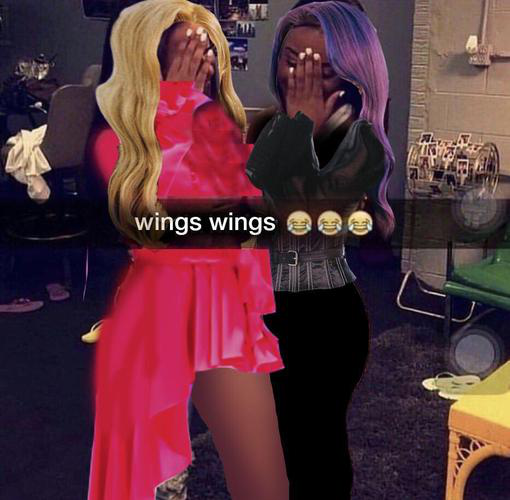

Predicted answer: yes
True answer: True


In [79]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

id = 0
tweet_text = df['tweet_text'].iloc[id]
tweet_id = df['tweet_id'].iloc[id]
tweet_label = df['is_hateful'].iloc[id]

img_path = "archive/img_resized/" + str(tweet_id) + ".jpg"

image = Image.open(img_path)
display(image)

text = "Is this image hateful? " + tweet_text

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor(image, text, return_tensors="pt", max_length=40, padding="max_length", truncation=True)

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])
print("True answer:", tweet_label)   

In [55]:
# Assumption: *get_visual_embeddings(image)* gets the visual embeddings of the image.
from transformers import AutoTokenizer, VisualBertModel, AutoImageProcessor
import torch

# def get_visual_embeddings(image_path):
#     # Load the image using PIL
#     image = Image.open(image_path)
#     # Preprocess the image
#     image = torchvision.transforms.ToTensor()(image).unsqueeze(0)
#     # Load the VisualBERT tokenizer
#     tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
#     # Preprocess the image
#     inputs = tokenizer(image, return_tensors="pt")
#     # Load the VisualBERT model
#     model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
#     # Get the visual embeddings
#     outputs = model.visual_embeds(**inputs)
#     return outputs

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

tweet_text = df['tweet_text'].iloc[id]
tweet_id = df['tweet_id'].iloc[id]

img_path = "archive/img_resized/" + str(tweet_id) + ".jpg"

image = Image.open(img_path)

inputs_text = tokenizer(text, return_tensors="pt")
inputs = image_processor(image, return_tensors="pt")


visual_embeds = outputs = model.visual_embeds(**inputs)
visual_token_type_ids = torch.zeros(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

print(inputs.input_ids.shape)  # torch.Size([1, 9])
print(inputs.visual_embeds.shape)  # torch.Size([1, 100, 4])
print(inputs.visual_token_type_ids.shape)  # torch.Size([1, 100])
print(inputs.visual_attention_mask.shape)  # torch.Size([1, 100])§


outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

/opt/homebrew/anaconda3/envs/deep-learning/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

AttributeError: 'VisualBertModel' object has no attribute 'visual_embeds'

In [20]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/opt/homebrew/anaconda3/envs/deep-learning/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [48]:
encoding = processor(image, text, return_tensors="pt", padding="max_length", max_length=max_seq_length, truncation=True)

from transformers import ViltForImagesAndTextClassification

model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-mlm")

RuntimeError: Trying to create tensor with negative dimension -768: [-768, -768]

In [ ]:
encoding.input_ids.shape, encoding.pixel_values.unsqueeze(0).shape

(torch.Size([1, 64]), torch.Size([1, 1, 3, 512, 384]))

In [ ]:
outputs = model(input_ids=encoding.input_ids, 
                pixel_values=encoding.pixel_values.unsqueeze(0))

logits = outputs.logits

ValueError: Make sure to match the number of images in the model with the number of images in the input.

In [ ]:
idx = outputs.logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])